In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0)

In [2]:
from matplotlib import rc
rc('font', size=14)

In [3]:
from numpy import loadtxt, arange, log, delete, array, ones, concatenate
from numpy.linalg import lstsq
from scipy.stats import f
from scipy.stats.mstats import normaltest
from pandas.stats.moments import ewma
from pandas import Series

In [4]:
from common import *

In [5]:
MAX_POW = 2
CRITICAL_F = 4.2

In [6]:
dataset = loadtxt('data.csv', skiprows=1, delimiter=',')
t = arange(dataset.shape[0])
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()
XS = [TimeSeries(x) for x in xs]

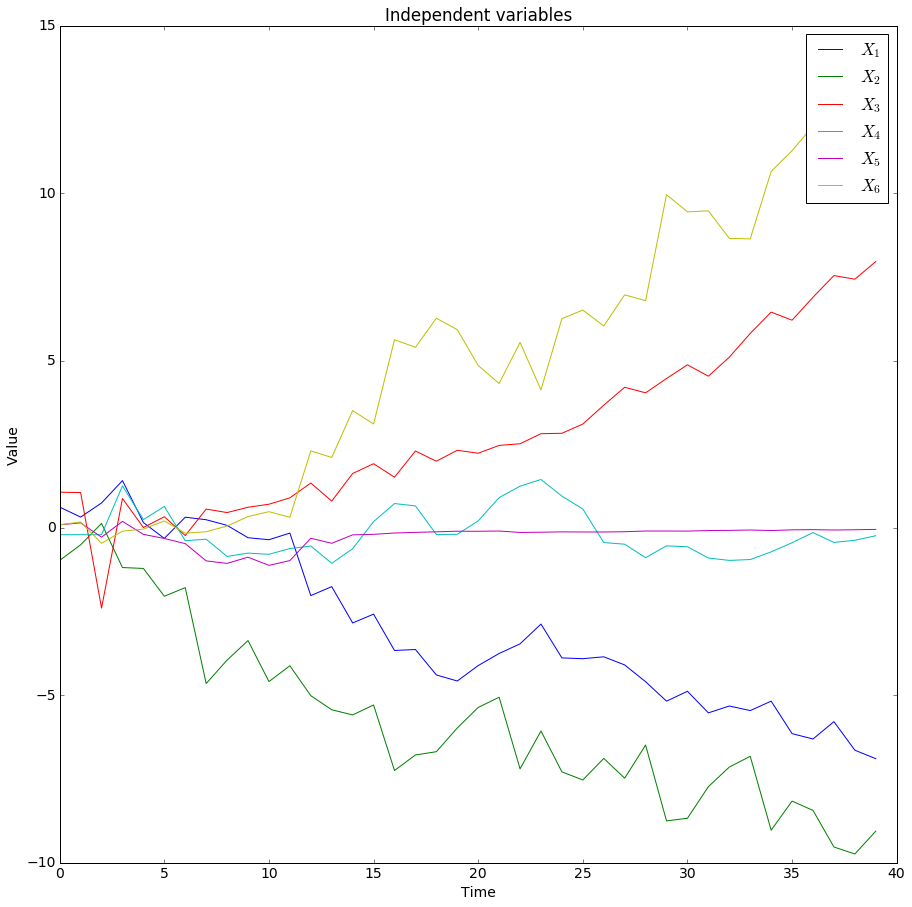

In [7]:
for i, x in enumerate(XS):
    plt.plot(t, x.data, label='$X_%d$'%(i+1))

plt.title('Independent variables')
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.show()

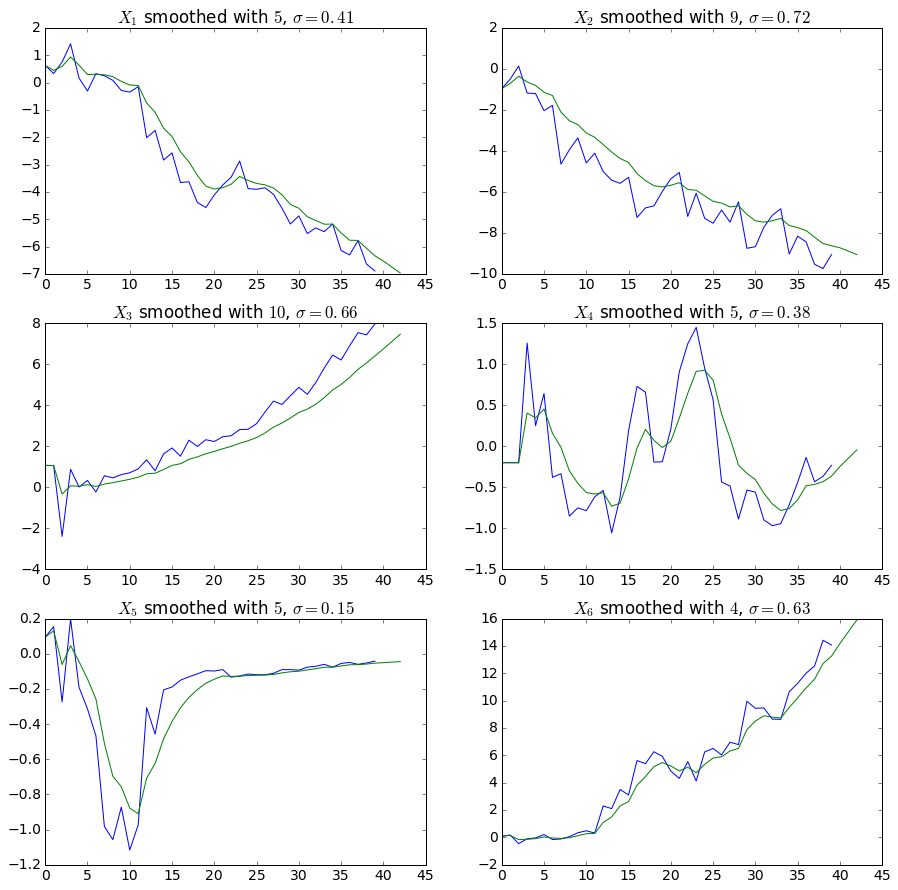

In [8]:
for i, x in enumerate(XS):
    i += 1
    plt.subplot(320 + i)
    plt.title(r'$X_{%d}$ smoothed with $%d$, $\sigma=%2.2f$'%(i, x.span, x.trend_errors.std()))
    plt.plot(x.data)
    plt.plot(x.trend_forecasted)
plt.show()

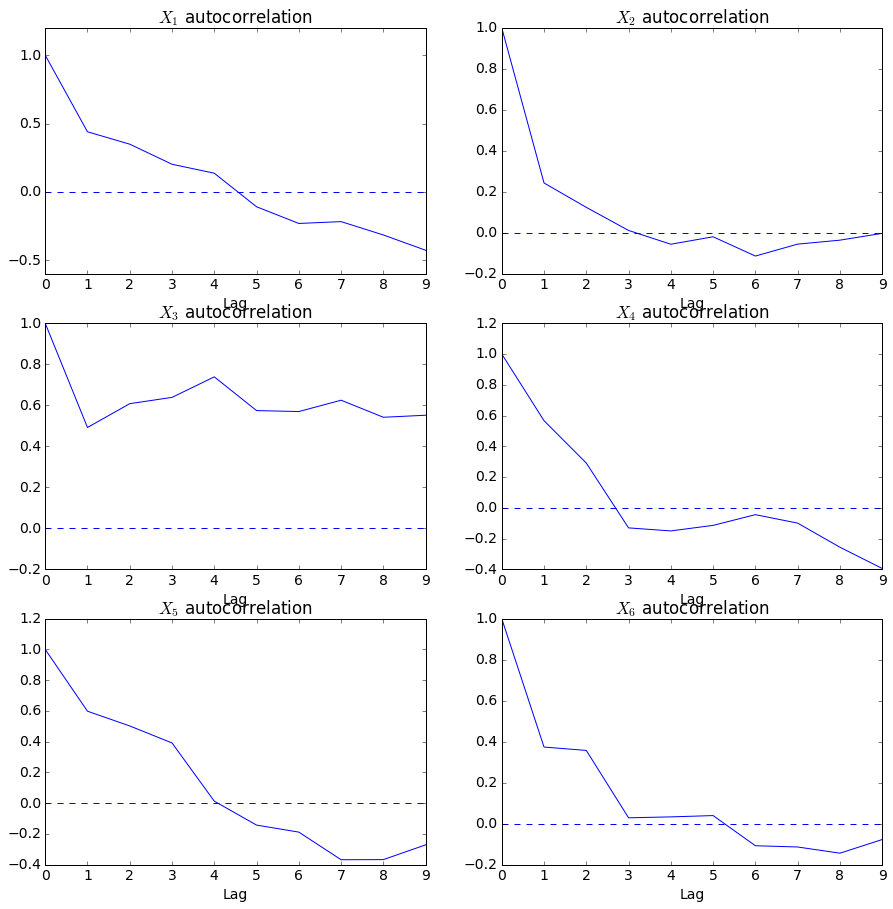

In [9]:
for i, x in enumerate(XS):
    i += 1
    plt.subplot(320 + i)
    plt.title(r'$X_{%d}$ autocorrelation'%i)
    plt.plot(x.autocorrelation)
    plt.axhline(linestyle='--')
    plt.xlabel('Lag')
plt.show()

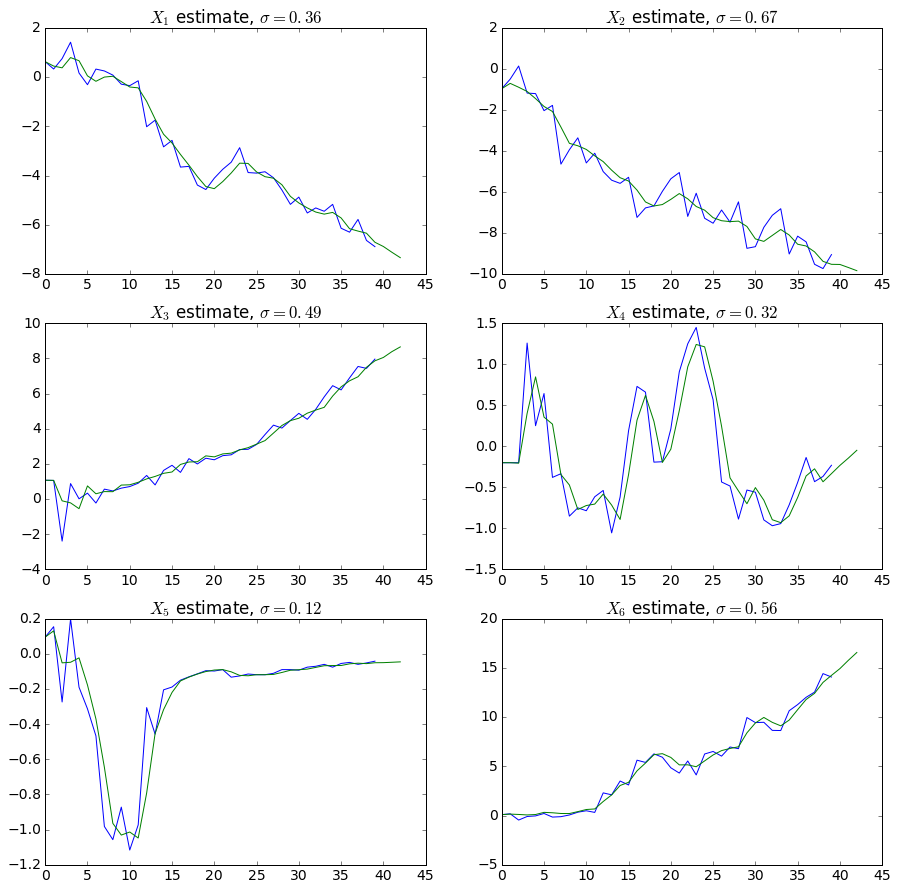

In [10]:
for i, x in enumerate(XS):
    i += 1
    plt.subplot(320 + i)
    plt.title(r'$X_{%d}$ estimate, $\sigma=%2.2f$'%(i, x.estimate_errors.std()))
    plt.plot(x.data)
    plt.plot(x.data_forecasted)
plt.show()

In [11]:
y_without_anomalies = y.copy()
for anomaly_point in (2, 12, 4):
    y_without_anomalies[anomaly_point] = .5 * (
        y_without_anomalies[anomaly_point - 1] + y_without_anomalies[anomaly_point + 1])

In [12]:
accum = [X.data_forecasted for X in XS]
names = ['X[%d]'%i for i in range(len(XS))]
sequences = [X.data_forecasted for X in XS]
for i in range(len(accum)):
    for j in range(i, len(accum)):
        sequences.append(accum[i] * accum[j])
        names.append('X[%d] * X[%d]'%(i, j))
sequences = array(sequences)

In [13]:
new_sequences = sequences.copy()
coefficients = [y_without_anomalies.mean()]
regressors = [ones(XS[0].data_forecasted.size)]
all_coefficients = [coefficients[0]]
all_regressors = [regressors[0]]
tmp_names = names.copy()
for i in range(min(sequences.shape[0], y.size)):
    regressors, coefficients, new_sequences, F, best = get_coeffs(y_without_anomalies, regressors, coefficients, new_sequences)
    all_coefficients.append(coefficients)
    all_regressors.append(regressors[-1])
    print('Step %d: the best is %s'%(i+1, tmp_names[best]))
    tmp_names = delete(tmp_names, best)
    if F < CRITICAL_F:
        print('Coefficients', coefficients.tolist())
        break
else:
    print('Best solution not found')

Step 1: the best is X[1] * X[5]
Step 2: the best is X[2] * X[4]
Step 3: the best is X[4] * X[5]
Coefficients [-3.3297720461223634, 1.7533891573018359, 15.590866650869222, 22.668791421642325]


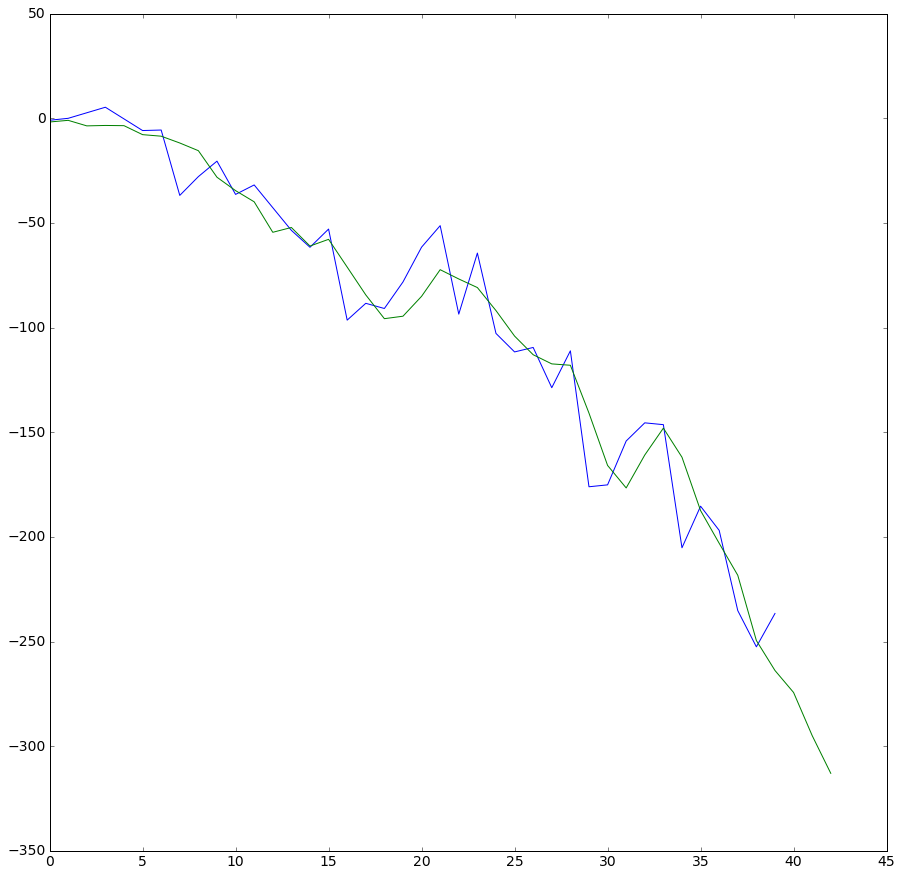

In [14]:
y_estimate = coefficients.dot(regressors)
plt.plot(y_without_anomalies)
plt.plot(y_estimate)
plt.show()